<font size="+3" color=blue><b> <center><u>Retina Damage Classification using Transfer Learning </u></center></b></font>

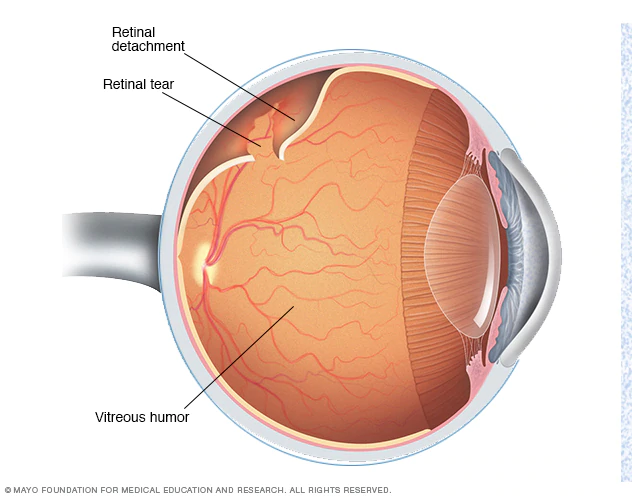

# Objective
Goal of this kernel is following:
- Learn how to implement FastAI on image data.
- Learn how to implement CNN on custom data.
- Learn how to Resnet to get better accuracy.
- Provide Perfect Guide for all the tips and trick to implement CNN and get better accuracy as a Beginner.

I have learned them from [FastAI](https://docs.fast.ai/)

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list"  role="tab" aria-controls="home">Table of content</h3>

<font color="blue" size=+1><b>Introduction</b></font>
* [1. What is CNN ?](#2)
* [2. What is Transfer Learning ?](#3) 
* [3. About Dataset ?] (#31)

<font color="blue" size=+1><b>Library</b></font>
* [1. Installation](#4)
* [2. Import Libraries ](#5)
    
<font color="blue" size=+1><b> Load and view your data </b></font>
* [1. Setting up path for training data ](#6)
* [2. Data Loading For training ](#7)
* [3. Data Explorations ](#8)
* [4. Print Classes present in the data ](#9)

<font color="blue" size=+1><b> Create and train a model </b></font>
* [1. Create Models ](#10)
* [2. Train Model ](#11)
* [3. Finding LR ](#12)
* [4. Finetuning HyperParameter](#13)

<font color="blue" size=+1><b> Others </b></font>
* [1. Interpret the results](#14)
* [2. Prediction Using Trained Model](#15)
* [3. Save and Load Model](#16)
* [4. Sources](#17)

<a id="1"></a>
<font color="blue" size=+2.5><b>Introduction</b></font>


<a id="2"></a>
<font color="blue" size=+2.5><b>1.2  What is CNN ?</b></font>
<br/>
<br/>
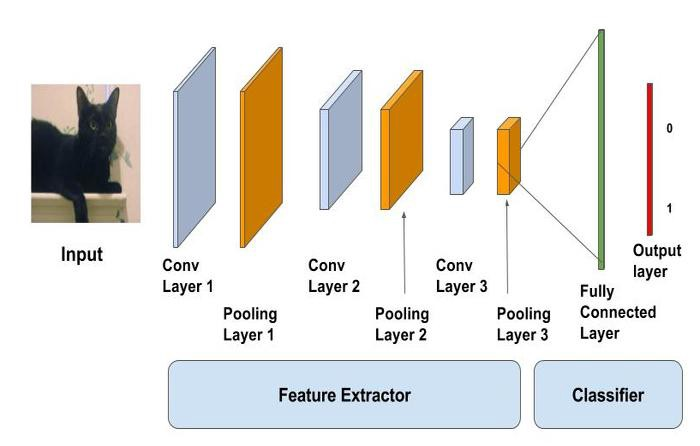
**CNN stands for Convolutional Neural Network which is a specialized neural network for processing data that has an input shape like a 2D matrix like images. CNN's are typically used for image detection and classification.**

<a id="3"></a>
<font color="blue" size=+2.5><b>1.3  What is Transfer Learning ?</b></font>
<br/>
<br/>

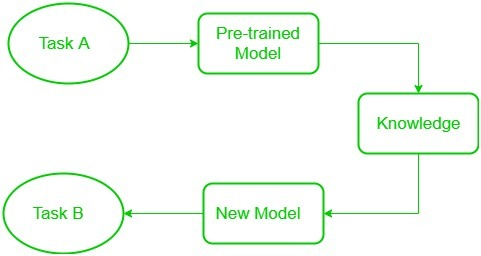

**Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.**

<a id="31"></a>
<font color="blue" size=+2.5><b>1.4  About Dataset </b></font>
<br/>
<br/>
## Detect Retina Damage From OCT Images


Using data from http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
It is often difficult to obtain large datasets of medical images. Here I demonstrate that transfer learning can be used to train a deep learning model using only a small dataset consisting of less than 1,000 retinal OCT images.

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

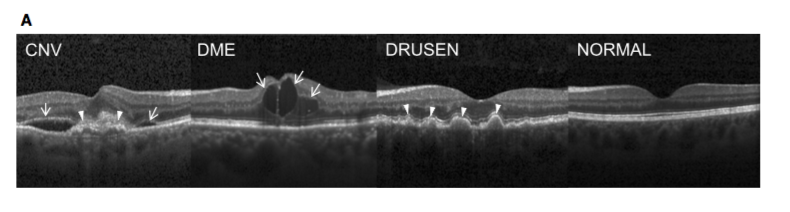

Figure 2. Representative Optical Coherence Tomography Images and the Workflow Diagram [Kermany et. al. 2018] http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

(A) (Far left) choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.


## Number of Labels

* DME
* CNV
* NORMAL
* DRUSEN

<a id="5"></a>


<font color="blue" size=+2.5><b>2. Library</b></font>

<a id="4"></a>
<font color="blue" size=+2.5><b>2.1 Installation</b></font>
* Numpy
* Pandas
* Matplotlib
* Fastai

<a id="5"></a>
<font color="blue" size=+2.5><b>2.2 Library Import</b></font>

In [ ]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np

<a id="6"></a>
<font color="blue" size=+2.5><b>3.1 Setting up path for training data</b></font>

**Point to be Noted: Number of elements in a list of path is same as number of classes you have**

In [ ]:
x  = "/kaggle/input/kermany2018/oct2017"
path = Path(x)
path.ls()

<a id="7"></a>
<font color="blue" size=+2.5><b>3.2 Data Loading For training</b></font>
<br/>

**Things to be remember:**
* Decide validation percentage ( 0.2 => 20% )
* Provide path for training data
* [Decide augmentations criteria (optional)](https://www.kaggle.com/init27/introduction-to-image-augmentation-using-fastai/)
* Decide image size (which is 224 in my case)
* Test data can also be added but it's optional

In [ ]:
np.random.seed(40)
data = ImageDataBunch.from_folder(path, train = '.', valid_pct=0.3,
                                  ds_tfms=get_transforms(), size=224,
                                  num_workers=4).normalize(imagenet_stats)

<a id="8"></a>
<font color="blue" size=+2.5><b>3.3 Data Explorations</b></font>
<br/>

*Our image dataset is stored as .jpg files in 4 different folders, with each folder bearing the name of model of the images contained in the folder. We use the ImageDataBunch.from_folder() function to load the images and assign labels the images based on the name of the folder they’re read from.*

In [ ]:
data.show_batch(rows=3, figsize=(7,6),recompute_scale_factor=True)


<a id="9"></a>
<font color="blue" size=+2.5><b>3.4 Print Classes present in the data</b></font>
<br/>

* data.c — How many classes are there in our dataset?
* len(data.train_ds) — What is the size of our training dataset?
* len(data.valid_ds) — What is the size of our validation dataset?

In [ ]:
print(data.classes)
len(data.classes)
data.c

In [ ]:
data

<a id="10"></a>
<font color="blue" size=+2.5><b>4.1 Create Model</b></font>
<br/>
* We now use a pre-trained ResNet18 Convolutional Neural Net model, and use transfer learning to learn weights of only the last layer of the network.
* Why Transfer learning? Because with transfer learning, you begin with an existing (trained) neural network used for image recognition — and then tweak it a bit (or more) here and there to train a model for your particular use case. And why do we do that? Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, we’re going to need at least a million images.
* In our case, we have approximately 40000+ images in our training set — you have one guess to decide if that would have been enough if were to train a neural net from scratch.
* We use the create_cnn() function for loading a pre-trained ResNet18 network, that was trained on around a million images from the ImageNet database.

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=[accuracy], model_dir = Path('../kaggle/working'),path = Path("."))

<a id="11"></a>
<font color="blue" size=+2.5><b>4.2 Finding LR</b></font>
<br/>

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestions=True)

<a id="12"></a>
<font color="blue" size=+2.5><b>4.3 Train Model</b></font>
<br/>

In [ ]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(1,slice(lr1,lr2))

In [ ]:
# lr1 = 1e-3
lr = 1e-1
learn.fit_one_cycle(1,slice(lr))

<a id="13"></a>
<font color="blue" size=+2.5><b>4.4 Hyper Parameter Tuning</b></font>
<br/>

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(1,slice(1e-4,1e-3))

In [ ]:
learn.recorder.plot_losses()


<a id="14"></a>
<font color="blue" size=+2.5><b>5.1 Interpret the results</b></font>
<br/>

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

<a id="16"></a>
<font color="blue" size=+2.5><b>5.3 Save and Load Model</b></font>
<br/>


In [ ]:
learn.export(file = Path("/kaggle/working/export.pkl"))
learn.model_dir = "/kaggle/working"
learn.save("stage-1",return_path=True)

<a id="17"></a>
<font color="blue" size=+2.5><b>5.4 Sources</b></font>
<br/>
* [Fastai MOOC](https://course.fast.ai/)
* [Fastai library](https://docs.fast.ai/)